In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from statsmodels.tsa.api import Holt
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [35]:
# Loading data
path = './'
raw_data = pd.read_csv(path+'sensordata.csv')
raw_data.head()

,id,sensorid,time,topic,value,location,coordinates
0,1,QMUL-WS-02,2022/7/28 15:38,/QMUL/CSEE/B312/NO2,0.15,GO,"51o31.41'N,00o02.50'W"
1,2,QMUL-WS-02,2022/7/28 15:38,/QMUL/CSEE/B312/CO,25.54,GO,"51o31.41'N,00o02.50'W"
2,3,QMUL-WS-02,2022/7/28 15:38,/QMUL/CSEE/B312/NH3,0.73,GO,"51o31.41'N,00o02.50'W"
3,4,QMUL-WS-02,2022/7/28 15:38,/QMUL/CSEE/B312/C4H5OH,16.50,GO,"51o31.41'N,00o02.50'W"
4,5,QMUL-WS-02,2022/7/28 15:38,/QMUL/CSEE/B312/H2,10.76,GO,"51o31.41'N,00o02.50'W"


# 1.The data are first pre-processed to remove non-conforming data. 

In [36]:
# Remove outliers from each gas
def outer(data):
    gases = data.gas.unique()
    outers = []
    for gas in gases:
        temp = data[data['gas']==gas]
        q1 = temp['value'].quantile(0.25)
        q3 = temp['value'].quantile(0.75)
        IQR = q3-q1
        vmax = q3+1.5*q1
        vmin = q3-1.5*q1
        
        for i in range(temp.shape[0]):
            t = temp.iloc[i,:]
            if t['value']<vmin or t['value']>vmax:
                outers.append(t['id']-1)
    return data.drop(outers)
                

data = raw_data.dropna()  #Delete empty values
data = data.drop_duplicates() #Delete duplicate values
data['gas'] = data['topic'].apply(lambda x:x.split('/')[-1])
data = outer(data)

['NO2' 'NH3' 'C3H8' 'C4H10' 'CO' 'H2' 'C4H5OH' 'CH4']


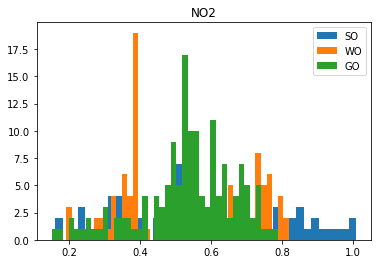

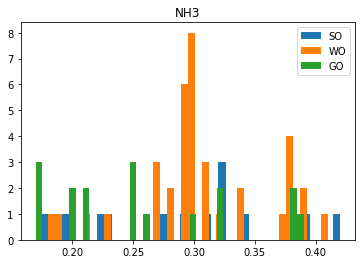

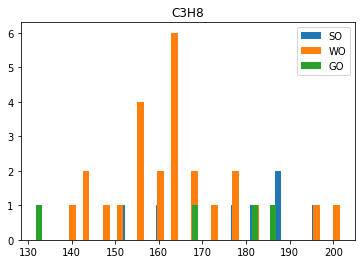

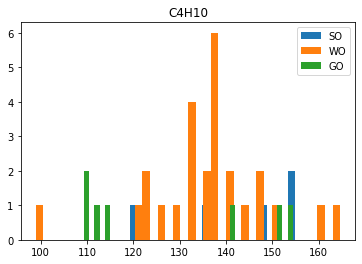

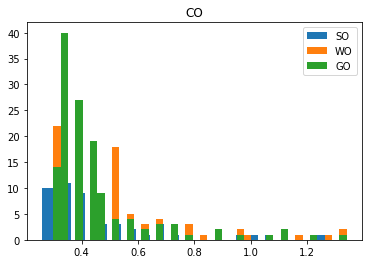

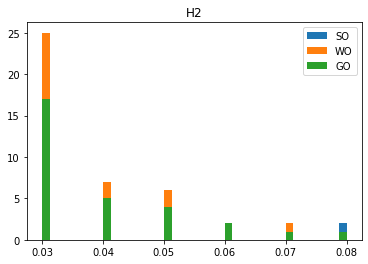

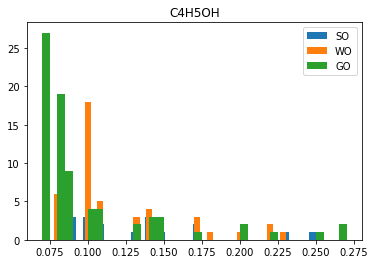

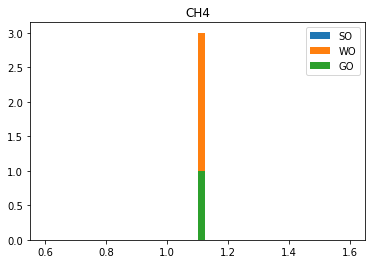

In [37]:
# Frequency graph for each gas value
gases = data.gas.unique()
print(gases)
for gas in gases:
    for s in ['SO','WO','GO']:
        t = data[data['gas']==gas]
        t = t[t['location'].str.contains(s)]
        plt.hist(t['value'], bins=40,label=s)
    plt.title(gas)
    plt.legend()
    plt.show()

['NO2' 'NH3' 'C3H8' 'C4H10' 'CO' 'H2' 'C4H5OH' 'CH4']


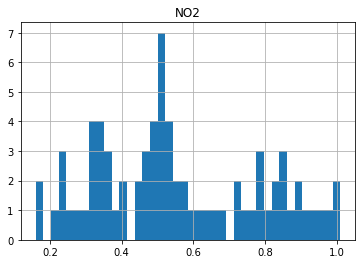

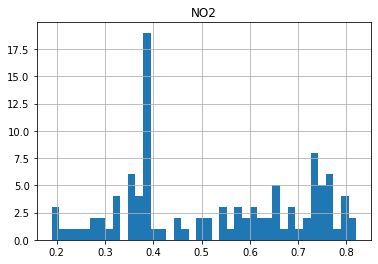

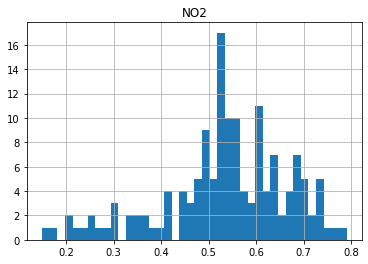

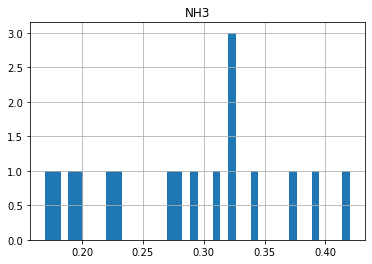

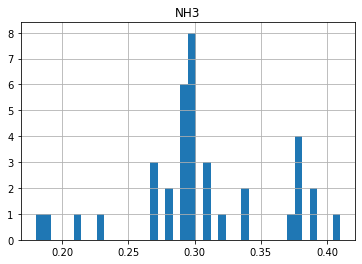

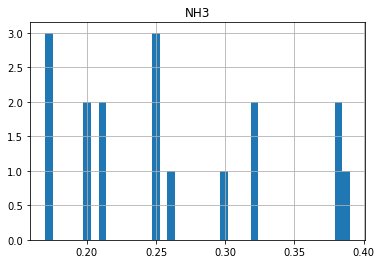

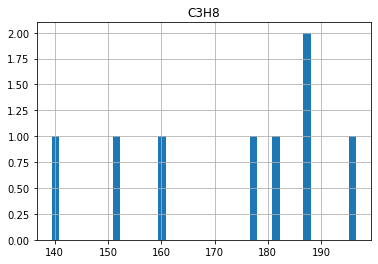

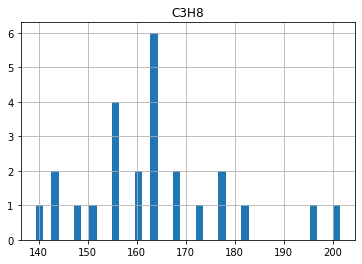

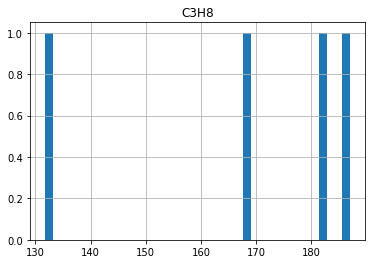

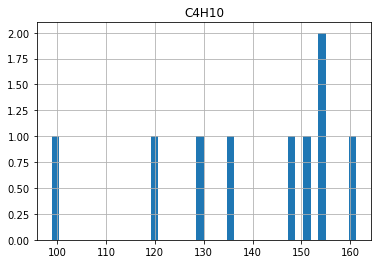

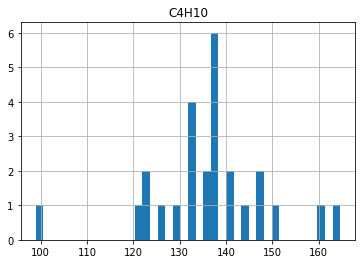

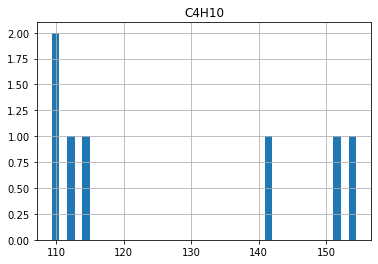

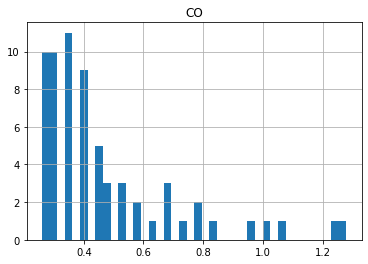

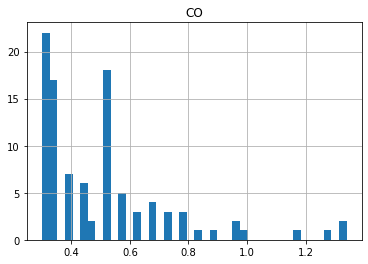

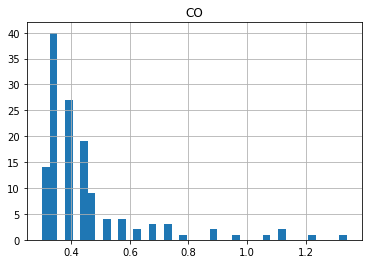

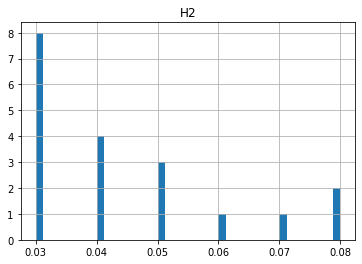

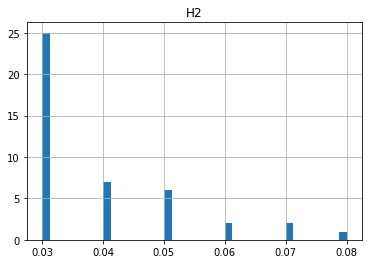

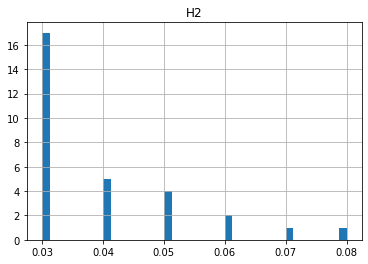

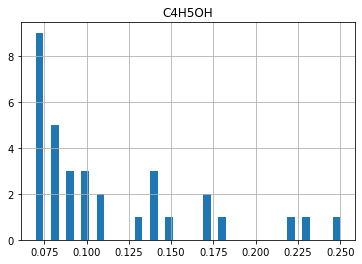

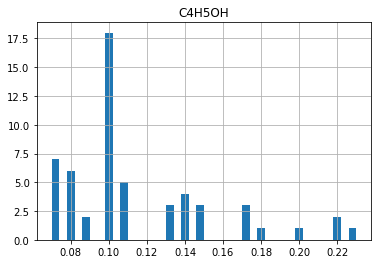

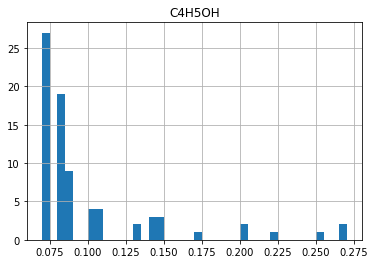

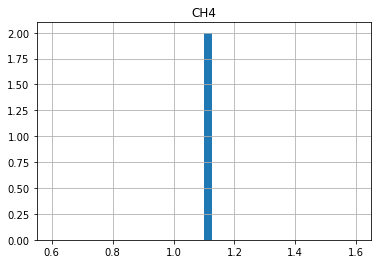

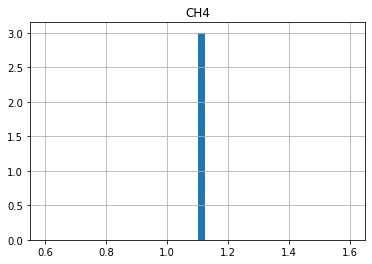

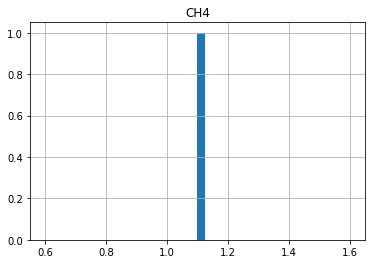

In [38]:
gases = data.gas.unique()
print(gases)
for gas in gases:
    for s in ['SO','WO','GO']:
        t = data[data['gas']==gas]
        t = t[t['location'].str.contains(s)]
        t.hist('value', bins=40)
        plt.title(gas)

### 2.Positive, negative or no correlation between indoor and outdoor gas concentration ratios using PCA analysis

In [39]:
# Collating data
data_2 = data.copy()
data_2['gas'] = data.apply(lambda x: x['gas']+'/'+x['location'][-1], axis = 1)
data_2['location'] = data['location'].apply(lambda x:x[:1])

data_2_S = []
for gas in data_2['gas'].unique():
    t = data_2[data_2['gas']==gas]
    t = t[t['location']=='S']
    data_2_S.append(t['value'].to_list())
data_2_S = pd.DataFrame(data_2_S).transpose()
data_2_S.columns = data_2['gas'].unique()

data_2_W = []
for gas in data_2['gas'].unique():
    t = data_2[data_2['gas']==gas]
    t = t[t['location']=='W']
    data_2_W.append(t['value'].to_list())
data_2_W = pd.DataFrame(data_2_W).transpose()
data_2_W.columns = data_2['gas'].unique()

data_2_G = []
for gas in data_2['gas'].unique():
    t = data_2[data_2['gas']==gas]
    t = t[t['location']=='G']
    data_2_G.append(t['value'].to_list())
data_2_G = pd.DataFrame(data_2_G).transpose()
data_2_G.columns = data_2['gas'].unique()
data_2_W

,NO2/O,NH3/O,C3H8/O,C4H10/O,CO/O,H2/O,C4H5OH/O,CO/I,NO2/I,H2/I,C4H5OH/I,NH3/I,CH4/I,C4H10/I,C3H8/I,CH4/O
0,0.20,0.30,168.54,141.45,1.34,0.08,0.23,1.17,0.39,0.06,0.20,0.17,1.1,NaN,NaN,1.1
1,0.23,0.32,182.20,151.12,1.00,0.06,0.18,0.89,0.40,0.05,0.17,0.18,1.1,NaN,NaN,1.1
2,0.28,0.27,143.37,123.29,0.84,0.05,0.15,0.79,0.43,0.05,0.15,0.18,NaN,NaN,NaN,1.1
3,0.32,0.23,201.56,98.92,0.74,0.04,0.13,0.74,0.45,0.04,0.14,0.17,NaN,NaN,NaN,NaN
4,0.36,0.19,177.56,164.65,0.63,0.03,0.11,0.68,0.47,0.04,0.14,0.17,NaN,NaN,NaN,NaN
5,0.39,0.41,173.01,147.85,0.58,0.03,0.10,0.68,0.48,0.04,0.13,0.17,NaN,NaN,NaN,NaN
6,0.42,0.39,155.61,144.62,0.53,0.03,0.09,0.63,0.49,0.04,0.13,NaN,NaN,NaN,NaN,NaN
7,0.45,0.38,151.46,132.17,0.48,0.07,0.08,0.63,0.49,0.03,0.11,NaN,NaN,NaN,NaN,NaN
8,0.46,0.39,155.61,129.17,0.44,0.06,0.08,0.58,0.51,0.03,0.11,NaN,NaN,NaN,NaN,NaN
9,0.49,0.38,147.38,132.17,0.44,0.05,0.08,0.58,0.51,0.03,0.11,NaN,NaN,NaN,NaN,NaN


In [40]:
# S_PCA
pca_S = decomposition.PCA(n_components=0.9)
data_2_S = data_2_S.fillna(0)
pca_S.fit(data_2_S)
pca_S.explained_variance_ratio_

array([0.87749769, 0.10236664])

In [41]:
# The larger the value, the larger the corresponding explained_variance_is
feature_value_S,_ = np.linalg.eig(np.cov(data_2_S.T))
feature_value_S

array([1.14976953e+04, 1.34129174e+03, 1.91564659e+02, 7.19454587e+01,
       1.58076412e-01, 6.96864498e-02, 3.72553303e-02, 2.67218721e-02,
       1.55583550e-02, 1.19523978e-02, 2.62345884e-03, 8.19606217e-04,
       6.42672799e-04, 4.92992590e-04, 6.44583107e-05, 4.11645844e-05])

In [42]:
data_2_S.corr()

,NO2/O,NH3/O,C3H8/O,C4H10/O,CO/O,H2/O,C4H5OH/O,CO/I,NO2/I,H2/I,C4H5OH/I,NH3/I,CH4/I,C4H10/I,C3H8/I,CH4/O
NO2/O,1.000000,-0.138812,-0.275193,-0.269655,-0.263147,-0.113453,0.230048,0.312319,0.003329,0.384815,0.376824,-0.064493,-0.270195,-0.156753,-0.195906,-0.219707
NH3/O,-0.138812,1.000000,0.678007,0.730520,0.261846,0.928575,0.649844,-0.024582,0.604797,0.515436,-0.021998,0.878947,0.422624,0.963819,0.938735,0.341567
C3H8/O,-0.275193,0.678007,1.000000,0.968589,0.421533,0.640848,0.404936,-0.013589,0.382249,0.142673,-0.011316,0.670719,0.716909,0.726977,0.768989,0.519743
C4H10/O,-0.269655,0.730520,0.968589,1.000000,0.413578,0.697478,0.403968,-0.014960,0.409731,0.151886,-0.012645,0.702577,0.690868,0.763595,0.806044,0.498442
CO/O,-0.263147,0.261846,0.421533,0.413578,1.000000,0.275680,0.116251,0.377677,0.106940,-0.087428,0.347605,0.252197,0.472235,0.303475,0.335621,0.456459
H2/O,-0.113453,0.928575,0.640848,0.697478,0.275680,1.000000,0.686396,-0.021426,0.622335,0.534856,-0.017941,0.892910,0.438395,0.907110,0.882284,0.424285
C4H5OH/O,0.230048,0.649844,0.404936,0.403968,0.116251,0.686396,1.000000,0.151420,0.671759,0.867491,0.169751,0.789257,0.408409,0.708301,0.645458,0.380124
CO/I,0.312319,-0.024582,-0.013589,-0.014960,0.377677,-0.021426,0.151420,1.000000,-0.229805,0.165629,0.933331,-0.021261,-0.006355,-0.024845,-0.022499,0.000187
NO2/I,0.003329,0.604797,0.382249,0.409731,0.106940,0.622335,0.671759,-0.229805,1.000000,0.680641,-0.241622,0.711231,0.256372,0.620342,0.570686,0.181068
H2/I,0.384815,0.515436,0.142673,0.151886,-0.087428,0.534856,0.867491,0.165629,0.680641,1.000000,0.184716,0.644498,0.098606,0.533170,0.458054,0.068749


In [43]:
# W_PCA
pca_W = decomposition.PCA(n_components=0.9)
data_2_W = data_2_W.fillna(0)
pca_W.fit(data_2_W)
pca_W.explained_variance_ratio_

array([0.98521978])

In [44]:
feature_value_W,_ = np.linalg.eig(np.cov(data_2_W.dropna().T))
feature_value_W

array([8.23228518e+03, 1.23202015e+02, 1.59027233e-01, 7.10463094e-02,
       3.27833102e-02, 2.13361978e-02, 5.08700549e-03, 4.45501709e-03,
       2.59452417e-03, 1.09669174e-03, 5.63142592e-04, 2.73654630e-04,
       8.28155800e-05, 9.02598525e-07, 0.00000000e+00, 0.00000000e+00])

In [45]:
data_2_W.corr()

,NO2/O,NH3/O,C3H8/O,C4H10/O,CO/O,H2/O,C4H5OH/O,CO/I,NO2/I,H2/I,C4H5OH/I,NH3/I,CH4/I,C4H10/I,C3H8/I,CH4/O
NO2/O,1.000000,0.239551,-0.035505,-0.006624,-0.599618,-0.005094,-0.121525,-0.353120,-0.118228,-0.350786,-0.370718,-0.302983,-0.232001,NaN,NaN,-0.265598
NH3/O,0.239551,1.000000,0.775946,0.797840,0.045298,0.832472,0.661520,0.525989,0.629698,0.474872,0.476267,0.296749,0.189547,NaN,NaN,0.218085
C3H8/O,-0.035505,0.775946,1.000000,0.969651,0.063055,0.704402,0.616827,0.488176,0.439130,0.414883,0.442715,0.475158,0.271622,NaN,NaN,0.308306
C4H10/O,-0.006624,0.797840,0.969651,1.000000,0.039996,0.708890,0.621645,0.486157,0.457482,0.418225,0.441367,0.433490,0.265296,NaN,NaN,0.304399
CO/O,-0.599618,0.045298,0.063055,0.039996,1.000000,0.311326,0.329302,0.441829,0.314602,0.446324,0.440155,0.359048,0.366135,NaN,NaN,0.380355
H2/O,-0.005094,0.832472,0.704402,0.708890,0.311326,1.000000,0.733838,0.626339,0.644856,0.584398,0.588866,0.386483,0.361896,NaN,NaN,0.390897
C4H5OH/O,-0.121525,0.661520,0.616827,0.621645,0.329302,0.733838,1.000000,0.795042,0.764148,0.781274,0.779589,0.340415,0.309503,NaN,NaN,0.332770
CO/I,-0.353120,0.525989,0.488176,0.486157,0.441829,0.626339,0.795042,1.000000,0.891687,0.953348,0.960307,0.373488,0.301802,NaN,NaN,0.328012
NO2/I,-0.118228,0.629698,0.439130,0.457482,0.314602,0.644856,0.764148,0.891687,1.000000,0.885703,0.874634,0.128341,0.050995,NaN,NaN,0.070312
H2/I,-0.350786,0.474872,0.414883,0.418225,0.446324,0.584398,0.781274,0.953348,0.885703,1.000000,0.996265,0.341489,0.253961,NaN,NaN,0.297514


In [46]:
# G_PCA
pca_G = decomposition.PCA(n_components=0.9)
data_2_G = data_2_G.fillna(0)
pca_G.fit(data_2_G)
pca_G.explained_variance_ratio_

array([0.75263348, 0.12587076, 0.10077731])

In [47]:
feature_value_G,_ = np.linalg.eig(np.cov(data_2_G.T))
feature_value_G

array([7.08121233e+03, 1.18426509e+03, 9.48171429e+02, 1.94734413e+02,
       1.24483611e-01, 2.95361847e-02, 1.65143215e-02, 6.49562716e-03,
       6.45547467e-03, 5.10247966e-03, 3.70587786e-03, 2.30653323e-03,
       1.44687175e-03, 6.88569425e-04, 2.78408086e-05, 4.32646397e-05])

In [48]:
data_2_G.corr()

,NO2/O,NH3/O,C3H8/O,C4H10/O,CO/O,H2/O,C4H5OH/O,CO/I,NO2/I,H2/I,C4H5OH/I,NH3/I,CH4/I,C4H10/I,C3H8/I,CH4/O
NO2/O,1.000000,-0.461197,-0.431160,-0.496728,-0.455128,-0.362641,-0.228762,-0.276116,0.388611,-0.248157,-0.233261,-0.108506,-0.485584,-0.354677,-0.347389,-0.241988
NH3/O,-0.461197,1.000000,0.488451,0.665293,0.357971,0.698746,0.359310,0.132301,0.210927,0.211022,0.172109,0.045715,0.592245,0.540869,0.719404,0.332778
C3H8/O,-0.431160,0.488451,1.000000,0.742549,0.461218,0.491127,0.369933,0.126562,0.016535,0.194564,0.153669,0.022024,0.803825,0.329583,0.390389,0.494119
C4H10/O,-0.496728,0.665293,0.742549,1.000000,0.444318,0.513247,0.374959,0.127035,0.068014,0.188370,0.155763,0.035142,0.927775,0.393339,0.468945,0.407780
CO/O,-0.455128,0.357971,0.461218,0.444318,1.000000,0.297767,0.384169,0.430008,0.051357,0.349630,0.381952,0.181203,0.450238,0.404412,0.250240,0.352085
H2/O,-0.362641,0.698746,0.491127,0.513247,0.297767,1.000000,0.528102,0.159242,0.356423,0.263780,0.211335,0.043401,0.509836,0.713238,0.928614,0.351043
C4H5OH/O,-0.228762,0.359310,0.369933,0.374959,0.384169,0.528102,1.000000,0.509551,0.144545,0.545152,0.526624,0.444246,0.379104,0.567040,0.465033,0.272137
CO/I,-0.276116,0.132301,0.126562,0.127035,0.430008,0.159242,0.509551,1.000000,0.172609,0.804529,0.867235,0.756222,0.128551,0.302162,0.147209,0.107401
NO2/I,0.388611,0.210927,0.016535,0.068014,0.051357,0.356423,0.144545,0.172609,1.000000,0.199285,0.237936,0.125193,0.051234,0.275596,0.373210,-0.001062
H2/I,-0.248157,0.211022,0.194564,0.188370,0.349630,0.263780,0.545152,0.804529,0.199285,1.000000,0.912824,0.888941,0.186888,0.393222,0.244449,0.181461


### 3. Specific values for the average indoor and outdoor gas concentration ratio (I/O)

In [49]:
data_2_S.columns

Index(['NO2/O', 'NH3/O', 'C3H8/O', 'C4H10/O', 'CO/O', 'H2/O', 'C4H5OH/O',
       'CO/I', 'NO2/I', 'H2/I', 'C4H5OH/I', 'NH3/I', 'CH4/I', 'C4H10/I',
       'C3H8/I', 'CH4/O'],
      dtype='object')

In [50]:
# S
print("H2:", np.mean(data_2_S['H2/I'])/np.mean(data_2_S['H2/O']))
print("CO:", np.mean(data_2_S['CO/I'])/np.mean(data_2_S['CO/O']))
print("NH3:", np.mean(data_2_S['NH3/I'])/np.mean(data_2_S['NH3/O']))
print("C4H10:", np.mean(data_2_S['C4H10/I'])/np.mean(data_2_S['C4H10/O']))
print("CH4:", np.mean(data_2_S['CH4/I'])/np.mean(data_2_S['CH4/O']))
print("C3H8:", np.mean(data_2_S['C3H8/I'])/np.mean(data_2_S['C3H8/O']))
print("NO2:", np.mean(data_2_S['NO2/I'])/np.mean(data_2_S['NO2/O']))
print("C4H5OH:", np.mean(data_2_S['C4H5OH/I'])/np.mean(data_2_S['C4H5OH/O']))

H2: 1.7261904761904763
CO: 1.1118012422360246
NH3: 1.392116182572614
C4H10: 1.9122417701714611
CH4: 2.0
C3H8: 1.7552121427174836
NO2: 0.5823244552058112
C4H5OH: 1.6577540106951871


In [51]:
# W
print("H2:", np.mean(data_2_W['H2/I'])/np.mean(data_2_W['H2/O']))
print("CO:", np.mean(data_2_W['CO/I'])/np.mean(data_2_W['CO/O']))
print("NH3:", np.mean(data_2_W['NH3/I'])/np.mean(data_2_W['NH3/O']))
print("C4H10:", np.mean(data_2_W['C4H10/I'])/np.mean(data_2_W['C4H10/O']))
print("CH4:", np.mean(data_2_W['CH4/I'])/np.mean(data_2_W['CH4/O']))
print("C3H8:", np.mean(data_2_W['C3H8/I'])/np.mean(data_2_W['C3H8/O']))
print("NO2:", np.mean(data_2_W['NO2/I'])/np.mean(data_2_W['NO2/O']))
print("C4H5OH:", np.mean(data_2_W['C4H5OH/I'])/np.mean(data_2_W['C4H5OH/O']))

H2: 1.311377245508982
CO: 0.7435641588505288
NH3: 0.09179170344218888
C4H10: 0.0
CH4: 0.6666666666666666
C3H8: 0.0
NO2: 0.5669014084507041
C4H5OH: 1.1145510835913313


In [52]:
# G
print("H2:", np.mean(data_2_G['H2/I'])/np.mean(data_2_G['H2/O']))
print("CO:", np.mean(data_2_G['CO/I'])/np.mean(data_2_G['CO/O']))
print("NH3:", np.mean(data_2_G['NH3/I'])/np.mean(data_2_G['NH3/O']))
print("C4H10:", np.mean(data_2_G['C4H10/I'])/np.mean(data_2_G['C4H10/O']))
print("CH4:", np.mean(data_2_G['CH4/I'])/np.mean(data_2_G['CH4/O']))
print("C3H8:", np.mean(data_2_G['C3H8/I'])/np.mean(data_2_G['C3H8/O']))
print("NO2:", np.mean(data_2_G['NO2/I'])/np.mean(data_2_G['NO2/O']))
print("C4H5OH:", np.mean(data_2_G['C4H5OH/I'])/np.mean(data_2_G['C4H5OH/O']))

H2: 3.8983050847457617
CO: 1.3476963871395427
NH3: 5.733634311512415
C4H10: 6.320146101531602
CH4: 5.999999999999999
C3H8: 6.696516595465
NO2: 0.6387454827052144
C4H5OH: 2.0296010296010296


### 4. Correlation between CO and NO2

In [53]:
co = data_2_G['CO/O']
no2 = data_2_G['NO2/O']
data_3 = pd.DataFrame({'CO':co,'NO2':no2})
data_3.corr()

,CO,NO2
CO,1.000000,-0.455128
NO2,-0.455128,1.000000


### 5. Changes in CO and NO2 levels in three outdoor areas

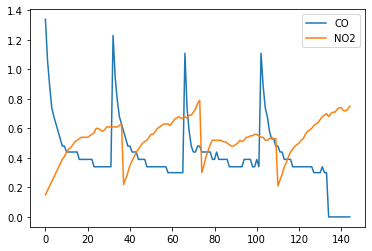

In [54]:
plt.plot(data_2_G['CO/O'], label='CO')
plt.plot(data_2_G['NO2/O'], label='NO2')

plt.legend()

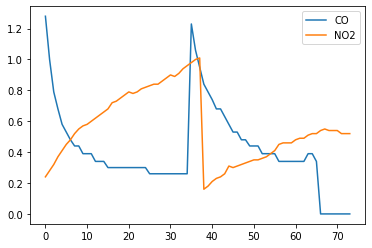

In [55]:
plt.plot(data_2_S['CO/O'], label='CO')
plt.plot(data_2_S['NO2/O'], label='NO2')

plt.legend()

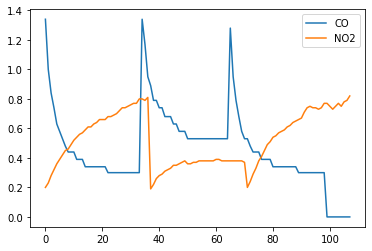

In [56]:
plt.plot(data_2_W['CO/O'], label='CO')
plt.plot(data_2_W['NO2/O'], label='NO2')

plt.legend()

### 7.A time series prediction model was used to predict and validate the change in gas over the next 12 hours.

In [57]:
data_7 = pd.read_csv('12_hours.csv')
data_NO2 = outer(data_7[data_7['gas']=='NO2'])
data_NH3 = outer(data_7[data_7['gas']=='NH3'])
data_C3H8 = outer(data_7[data_7['gas']=='C3H8'])

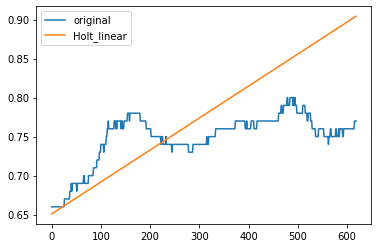

MSE: 0.004155200763744285


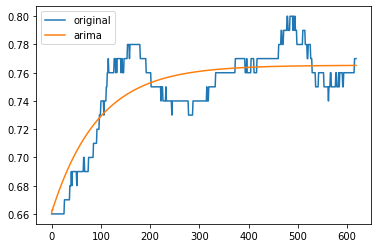

MSE: 0.00029303884823386544


In [58]:
# Prediction of NO2
#HOLT
train_NO2 = data_NO2[:len(data_NO2)//2]
test_NO2 = data_NO2[len(data_NO2)//2:]
holt = Holt(train_NO2['value']).fit(smoothing_level=0.01, smoothing_trend=0.01)
y = holt.forecast(len(test_NO2))
plt.plot(test_NO2['value'].to_list(), label='original')
plt.plot(y.to_list(), label='Holt_linear')
plt.legend(loc='best')
plt.show()
print("MSE:",np.mean((np.array(test_NO2['value'].to_list())- np.array(y.to_list()))**2))

#ARIMI
arima = ARIMA(train_NO2['value'], order=(3, 1, 3)).fit()
y = arima.forecast(len(test_NO2))
plt.plot(test_NO2['value'].to_list(), label='original')
plt.plot(y.to_list(), label='arima')
plt.legend(loc='best')
plt.show()
print("MSE:",np.mean((np.array(test_NO2['value'].to_list())- np.array(y.to_list()))**2))

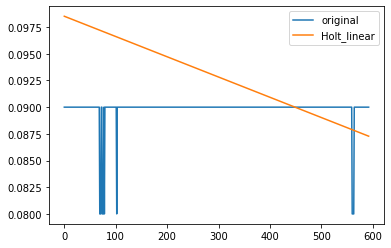

MSE: 2.2593946954224682e-05


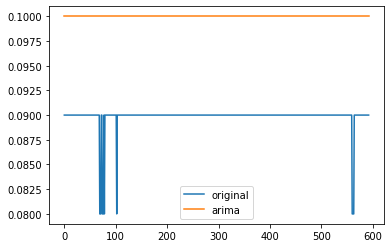

MSE: 0.00010607083676740843


In [59]:
# Prediction of NH3
#HOLT
train_NH3 = data_NH3[:len(data_NH3)//2]
test_NH3 = data_NH3[len(data_NH3)//2:]
holt = Holt(train_NH3['value']).fit(smoothing_level=0.1, smoothing_trend=0.1)
y = holt.forecast(len(test_NH3))
plt.plot(test_NH3['value'].to_list(), label='original')
plt.plot(y.to_list(), label='Holt_linear')
plt.legend(loc='best')
plt.show()
print("MSE:",np.mean((np.array(test_NH3['value'].to_list())-np.array(y.to_list()))**2))

#ARIMI
arima = ARIMA(train_NH3['value'], order=(2, 1, 2)).fit()
y = arima.forecast(len(test_NH3))
plt.plot(test_NH3['value'].to_list(), label='original')
plt.plot(y.to_list(), label='arima')
plt.legend(loc='best')
plt.show()
print("MSE:",np.mean((np.array(test_NH3['value'].to_list())-np.array(y.to_list()))**2))

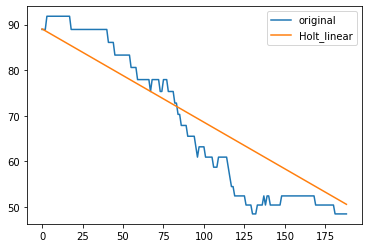

MSE: 38.295104894320225


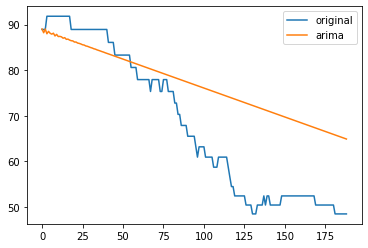

MSE: 166.11174174866417


In [63]:
# Prediction of C3H8
#HOLT
train_C3H8 = data_C3H8[:len(data_C3H8)//2]
test_C3H8 = data_C3H8[len(data_C3H8)//2:]
holt = Holt(train_C3H8['value']).fit(smoothing_level=0.1, smoothing_trend=0.1)
y = holt.forecast(len(test_C3H8))
plt.plot(test_C3H8['value'].to_list(), label='original')
plt.plot(y.to_list(), label='Holt_linear')
plt.legend(loc='best')
plt.show()
print("MSE:",np.mean((np.array(test_C3H8['value'].to_list())-np.array(y.to_list()))**2))

#ARIMI
arima = ARIMA(train_C3H8['value'], order=(3, 2, 3)).fit()
y = arima.forecast(len(test_C3H8))
plt.plot(test_C3H8['value'].to_list(), label='original')
plt.plot(y.to_list(), label='arima')
plt.legend(loc='best')
plt.show()
print("MSE:",np.mean((np.array(test_C3H8['value'].to_list())-np.array(y.to_list()))**2))